In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
df = pd.read_csv("2018.csv",sep=',')
df.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340
2,3,Denmark,7.555,1.351,1.590,0.868,0.683,0.284,0.408
3,4,Iceland,7.495,1.343,1.644,0.914,0.677,0.353,0.138
4,5,Switzerland,7.487,1.420,1.549,0.927,0.660,0.256,0.357


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


In [17]:
# Clean column names: remove whitespace, replace spaces with underscores, and convert to lowercase
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()


# Drop 'Country' column
df = df.drop(columns=['country_or_region'])

# Verify the cleaned column names
print(df.columns)

Index(['overall_rank', 'score', 'gdp_per_capita', 'social_support',
       'healthy_life_expectancy', 'freedom_to_make_life_choices', 'generosity',
       'perceptions_of_corruption'],
      dtype='object')


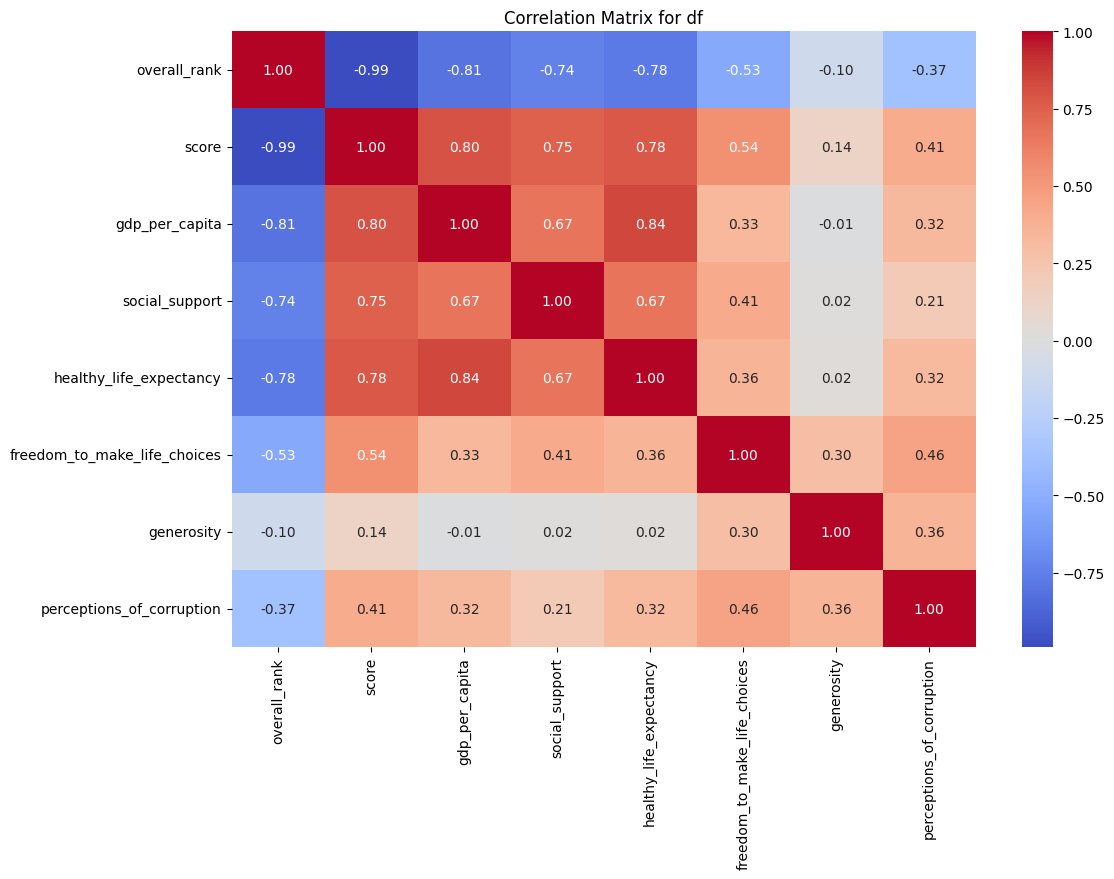

In [18]:
# Plot the correlation matrix for df
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix for df")
plt.show()

In [19]:
# Define dependent and independent variables
dependent_var = 'score'
independent_vars = [col for col in df.columns if col != dependent_var]

# Split the data into train and test sets
X = df[independent_vars]
y = df[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Check for Redundancy of Predictors
# Use correlation matrix (e.g., Variance Inflation Factor - VIF) to identify redundant predictors
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
                        feature        VIF
0                  overall_rank   3.026947
1                gdp_per_capita  33.781701
2                social_support  29.397663
3       healthy_life_expectancy  30.375240
4  freedom_to_make_life_choices  14.626508
5                    generosity   5.194903
6     perceptions_of_corruption   3.486155


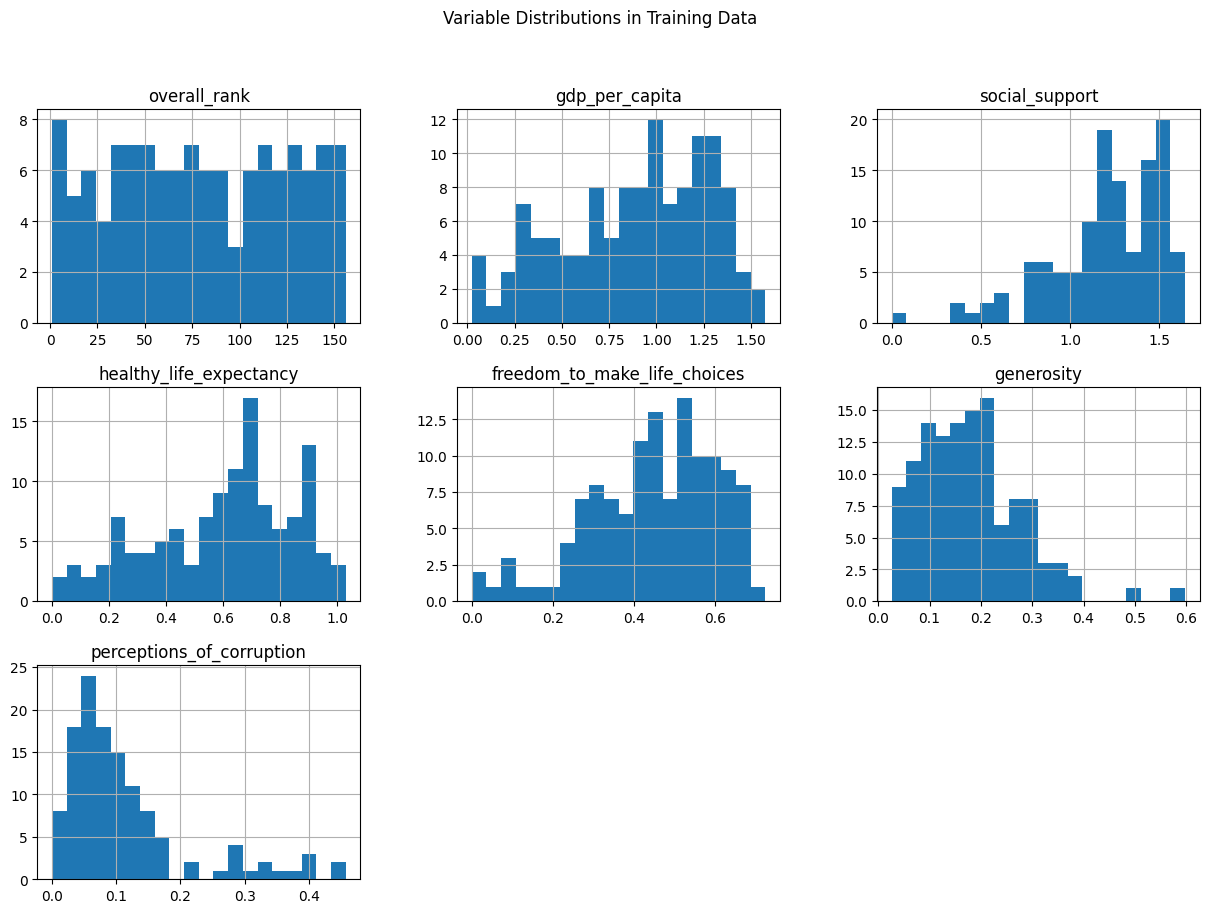

In [21]:
# Inspect Distributions
# Check the distributions of variables through histograms
X_train.hist(bins=20, figsize=(15, 10))
plt.suptitle("Variable Distributions in Training Data")
plt.show()

count    124.000000
mean       5.360726
std        1.144025
min        2.905000
25%        4.436750
50%        5.414000
75%        6.147500
max        7.632000
Name: score, dtype: float64


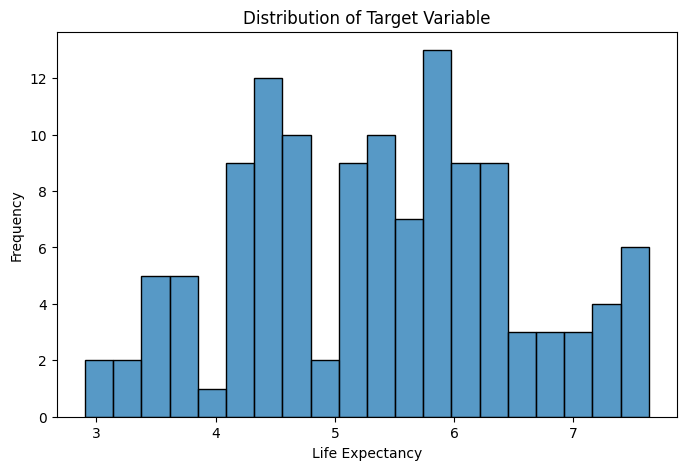

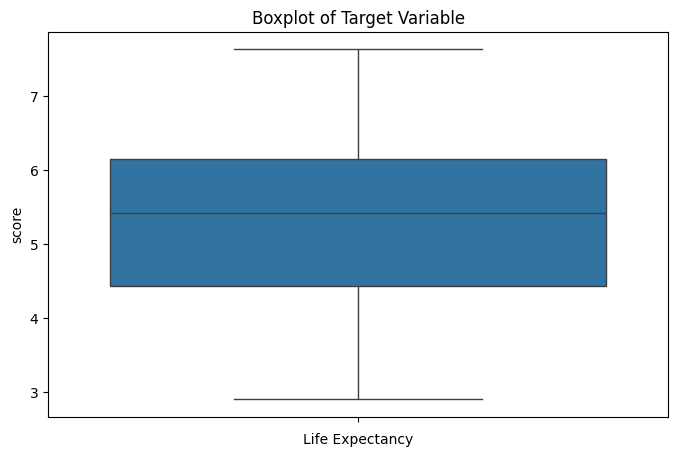

Shapiro-Wilk Test: Statistic = 0.98126971469728 , p-value = 0.08311643931921825
The target variable appears to be normally distributed.


In [22]:
# Check the distribution of the target variable
print(y_train.describe())

plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=20)
plt.title("Distribution of Target Variable")
plt.xlabel("Life Expectancy")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(y=y_train)
plt.title("Boxplot of Target Variable")
plt.xlabel("Life Expectancy")
plt.show()

from scipy.stats import shapiro
stat, p = shapiro(y_train)
print("Shapiro-Wilk Test: Statistic =", stat, ", p-value =", p)

if p > 0.05:
    print("The target variable appears to be normally distributed.")
else:
    print("The target variable does not appear to be normally distributed.")

In [27]:
formula = 'score ~ 1'
model = smf.glm(formula, df, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
predictions = result.predict()
print("AIC", result.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  score   No. Observations:                  156
Model:                            GLM   Df Residuals:                      155
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -293.67
Date:                Thu, 12 Dec 2024   Deviance:                       36.719
Time:                        11:20:54   Pearson chi2:                     36.1
No. Iterations:                     4   Pseudo R-squ. (CS):          7.772e-16
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6819      0.035     48.708      0.0

Poisson GLM Mean Squared Error: 0.026616756212656897
Poisson GLM Mean Absolute Error: 0.126991193483876
Poisson GLM R-squared: 0.9742984638196187


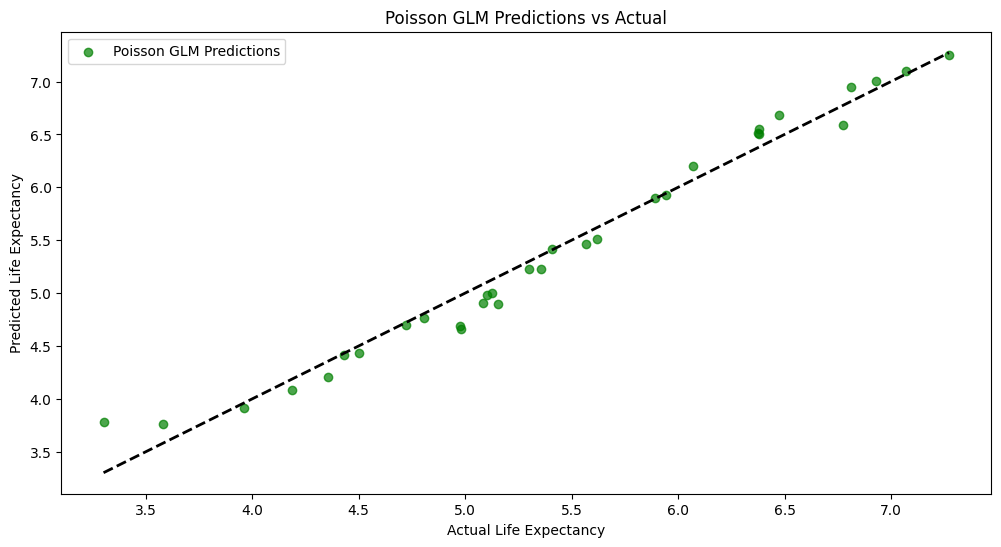

In [24]:
# Add a constant for GLM
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit a Generalized Linear Model (GLM) with Poisson family
poisson_model = sm.GLM(y_train, X_train_const, family=sm.families.Poisson(link=sm.families.links.log())).fit()

# Predictions using Poisson GLM
gamma_predictions = poisson_model.predict(X_test_const)

# Model evaluation for Poisson GLM
print("Poisson GLM Mean Squared Error:", mean_squared_error(y_test, gamma_predictions))
print("Poisson GLM Mean Absolute Error:", mean_absolute_error(y_test, gamma_predictions))
print("Poisson GLM R-squared:", r2_score(y_test, gamma_predictions))

# Compare predictions visually
plt.figure(figsize=(12, 6))

# Scatter plot for Poisson GLM predictions
plt.scatter(y_test, gamma_predictions, label="Poisson GLM Predictions", alpha=0.7, color='green')

# Identity line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Plot labels and title
plt.title("Poisson GLM Predictions vs Actual")
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.legend()
plt.show()

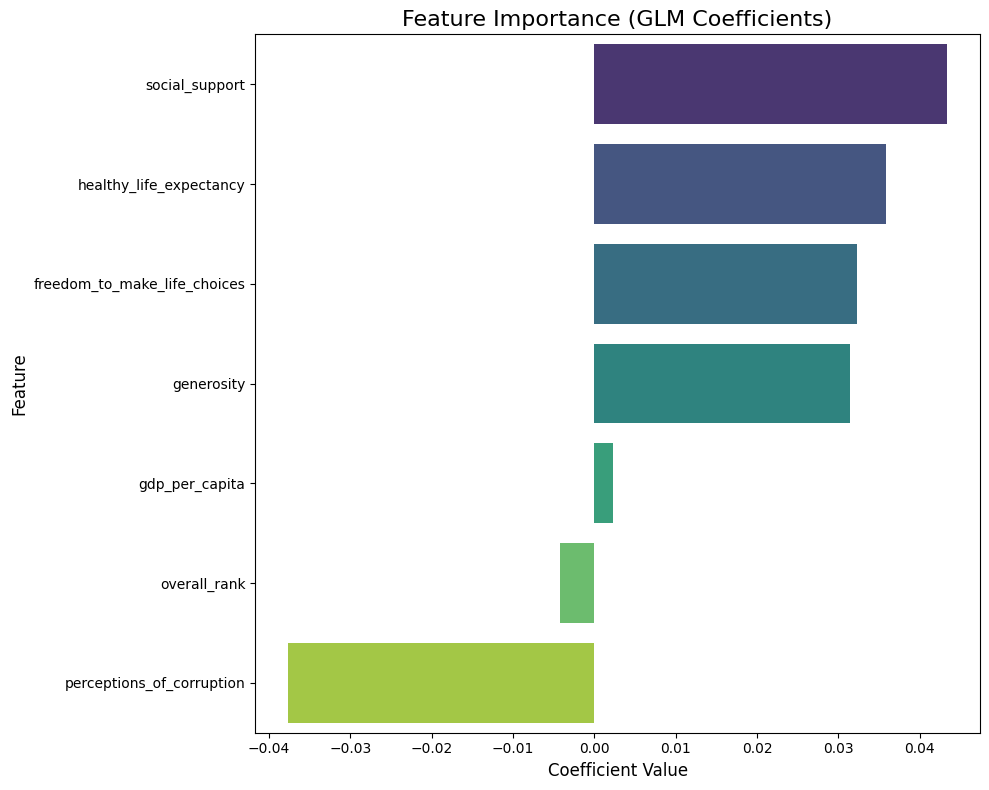

In [25]:
# Extract GLM coefficients
glm_coefficients = poisson_model.params

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': glm_coefficients.index,
    'Coefficient': glm_coefficients.values
}).sort_values(by='Coefficient', ascending=False)

# Exclude 'const' from the plot
feature_importance_no_const = feature_importance[feature_importance['Feature'] != 'const']

# Plot the Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_no_const, y='Feature', x='Coefficient', palette='viridis')
plt.title('Feature Importance (GLM Coefficients)', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

In [33]:
aic_table = pd.DataFrame()
formula = 'score ~ gdp_per_capita + social_support + healthy_life_expectancy'
model = smf.glm(formula, df, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
print("AIC", result.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  score   No. Observations:                  156
Model:                            GLM   Df Residuals:                      152
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -279.85
Date:                Thu, 12 Dec 2024   Deviance:                       9.0802
Time:                        11:25:22   Pearson chi2:                     9.05
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1624
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [35]:
import statsmodels.api as sm

# Function to reduce model using AIC
def reduce_model_aic(X, y):
    X = sm.add_constant(X)  # Add constant term
    best_aic = float('inf')
    best_model = None
    best_features = X.columns

    while True:
        model = sm.OLS(y, X).fit()  # Fit OLS model
        current_aic = model.aic
        print(f"Current AIC: {current_aic}")

        if current_aic < best_aic:
            best_aic = current_aic
            best_model = model
            best_features = X.columns
        else:
            break
        
        # Remove one feature at a time and evaluate AIC
        aic_values = {}
        for feature in X.columns:
            if feature != 'const':  # Skip the constant
                X_temp = X.drop(columns=[feature])
                temp_model = sm.OLS(y, X_temp).fit()
                aic_values[feature] = temp_model.aic

        # Find the feature whose removal minimizes AIC
        feature_to_remove = min(aic_values, key=aic_values.get)
        print(f"Removing {feature_to_remove} with AIC {aic_values[feature_to_remove]}")
        X = X.drop(columns=[feature_to_remove])

    print("Final Model:")
    print(best_model.summary())
    return best_model, best_features

# Apply the reduction function
X = df[['overall_rank', 'gdp_per_capita', 'social_support', 'healthy_life_expectancy', 
        'freedom_to_make_life_choices', 'generosity', 'perceptions_of_corruption']]
y = df['score']  # Replace with your actual target variable
final_model, final_features = reduce_model_aic(X, y)

Current AIC: -176.43875085573984
Removing healthy_life_expectancy with AIC -178.43306459803307
Current AIC: -178.43306459803307
Removing gdp_per_capita with AIC -180.35248866957886
Current AIC: -180.35248866957886
Removing freedom_to_make_life_choices with AIC -182.2910320846637
Current AIC: -182.2910320846637
Removing generosity with AIC -178.8801084221219
Current AIC: -178.8801084221219
Final Model:
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2716.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):          1.65e-139
Time:                        11:32:55   Log-Likelihood:                 96.146
No. Observations:                 156   AIC:                            -182.3
Df Residuals:                     151   BI

Training Metrics:
R²: 0.9859, Adjusted R²: 0.9853
MSE: 0.0183, MAE: 0.1047, RMSE: 0.1354

Test Metrics:
R²: 0.9883, Adjusted R²: 0.9860
MSE: 0.0122, MAE: 0.0891, RMSE: 0.1103



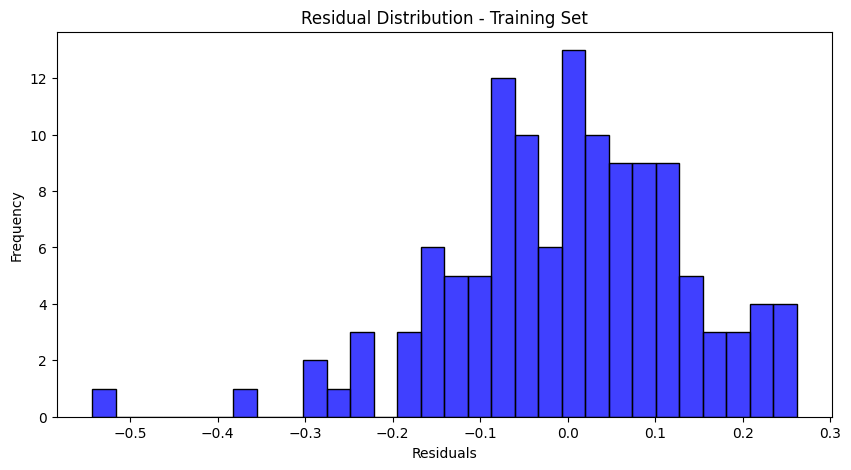

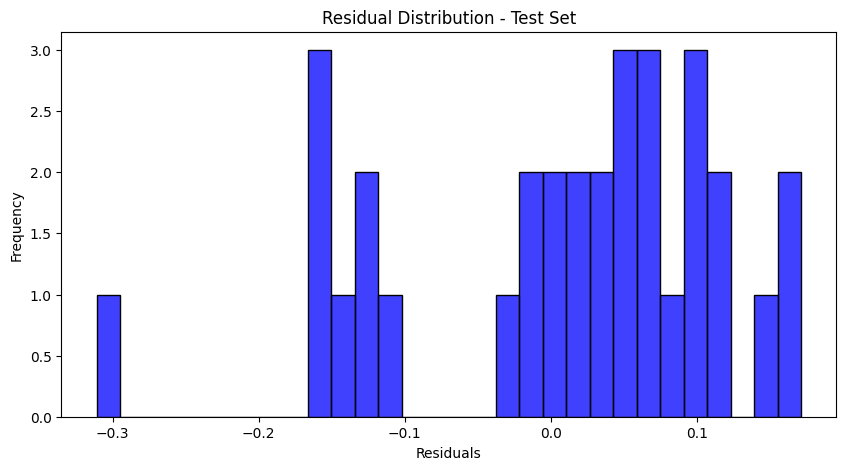

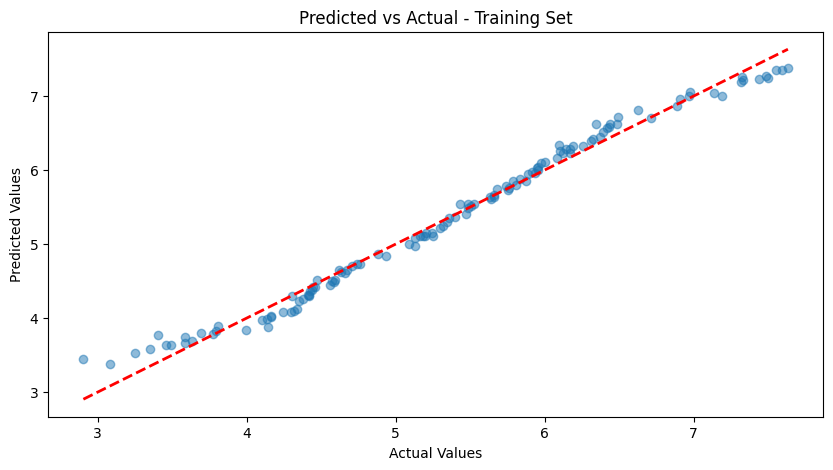

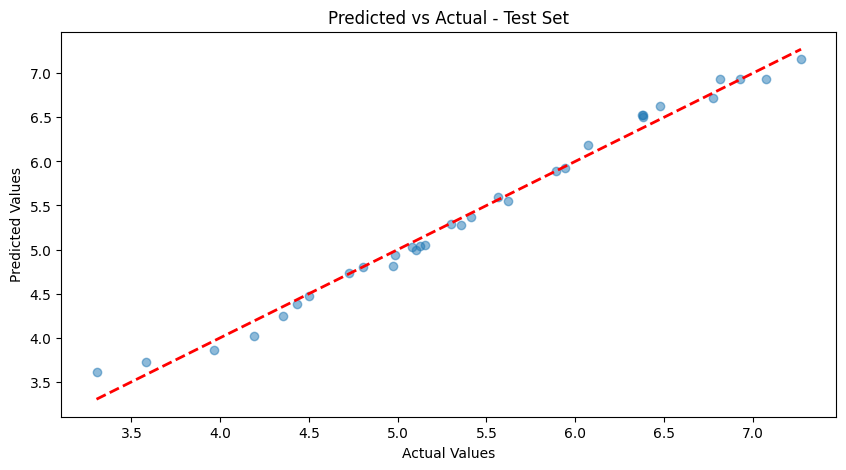

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate and display metrics
def calculate_metrics(model, X_train, y_train, X_test, y_test):
    # Predictions for training and test sets
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Training set metrics
    train_mse = mean_squared_error(y_train, train_preds)
    train_mae = mean_absolute_error(y_train, train_preds)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, train_preds)
    train_adj_r2 = 1 - (1 - train_r2) * ((len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1))

    # Test set metrics
    test_mse = mean_squared_error(y_test, test_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, test_preds)
    test_adj_r2 = 1 - (1 - test_r2) * ((len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
    
    print("Training Metrics:")
    print(f"R²: {train_r2:.4f}, Adjusted R²: {train_adj_r2:.4f}")
    print(f"MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}\n")
    
    print("Test Metrics:")
    print(f"R²: {test_r2:.4f}, Adjusted R²: {test_adj_r2:.4f}")
    print(f"MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}\n")
    
    return train_preds, test_preds

# Visualize residuals
def plot_residuals(y_true, y_pred, dataset_type):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=False, bins=30, color='blue')
    plt.title(f'Residual Distribution - {dataset_type}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

# Visualize predicted vs. actual
def plot_predicted_vs_actual(y_true, y_pred, dataset_type):
    plt.figure(figsize=(10, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(f'Predicted vs Actual - {dataset_type}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

# Filter X_train_const and X_test_const to only include the final features
X_train_const_filtered = X_train_const[final_features]
X_test_const_filtered = X_test_const[final_features]

# Calculate metrics and visualize
train_preds, test_preds = calculate_metrics(final_model, X_train_const_filtered, y_train, X_test_const_filtered, y_test)

# Residual plots
plot_residuals(y_train, train_preds, "Training Set")
plot_residuals(y_test, test_preds, "Test Set")

# Predicted vs Actual plots
plot_predicted_vs_actual(y_train, train_preds, "Training Set")
plot_predicted_vs_actual(y_test, test_preds, "Test Set")

1.	High R² and Adjusted R²:
	* The R² values (0.9859 for training and 0.9883 for testing) suggest that the model explains a very high proportion of the variance in the target variable.
	* The Adjusted R² values (0.9853 for training and 0.9860 for testing) confirm that the model remains robust even when accounting for the number of predictors.
2.	Low MSE, MAE, and RMSE:
	* The Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) values are very low for both datasets, showing that the model’s predictions are close to the actual values.
	* The Mean Absolute Error (MAE) further supports this, highlighting the minimal average absolute difference between predicted and actual values.
3. The residual distributions in both the training and test sets are relatively centered around zero, which indicates that the model is not systematically over- or under-predicting. However, there might be outliers in the residuals that could influence the model’s performance.